### Get dot coordinates using blob_log from skimage library

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import skimage.feature
%matplotlib inline

In [2]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups", "error"]
coords_cols = ["filename", "x", "y", "category"]

file_names = os.listdir("/data/x/sealion/Train")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

#indices = [531, 946, 34, 30, 290, 406, 380, 913, 621, 811, 7, 421, 292, 66, 593, 490, 909, 800, 215, 
#           426, 475, 614, 184, 905, 97, 882, 776, 899, 344, 473, 510, 234, 291, 331, 433, 712, 741, 767, 912]
indices = [290, 291]
# select a subset of files to run on
file_names = [file_names[i] for i in indices]

290.jpg


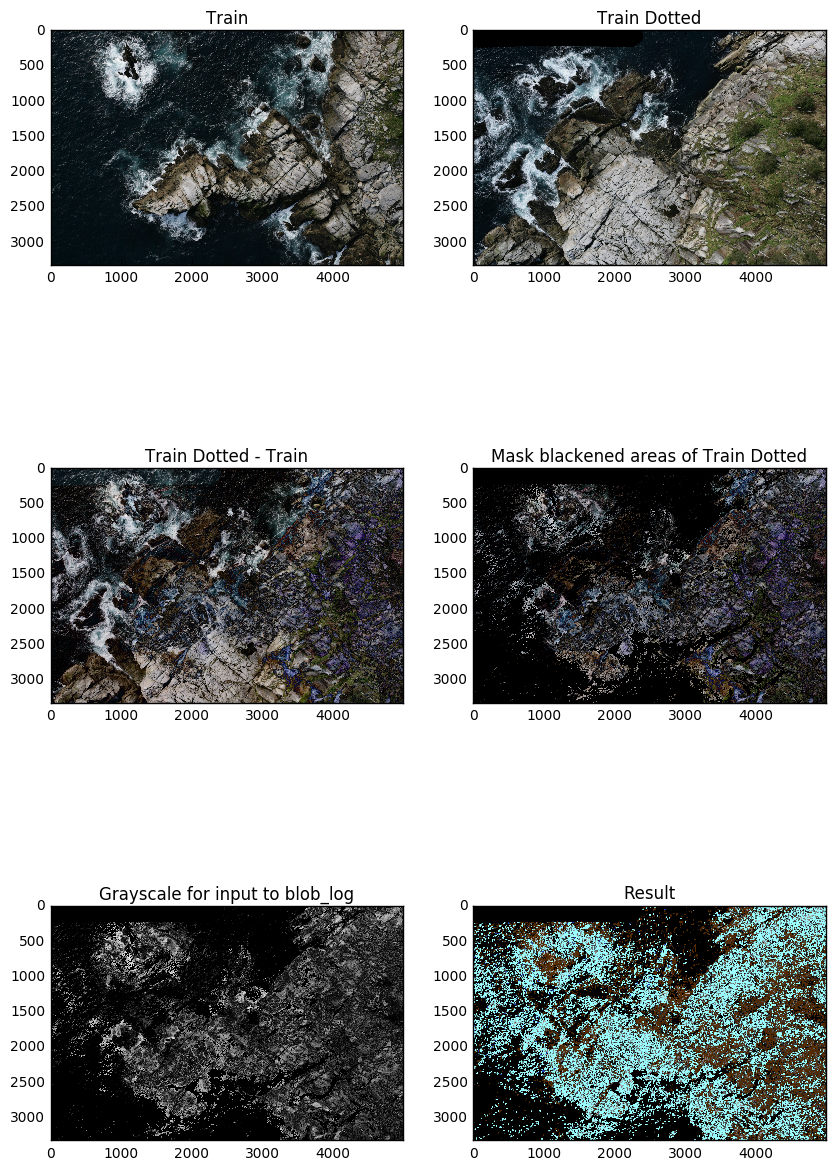

291.jpg


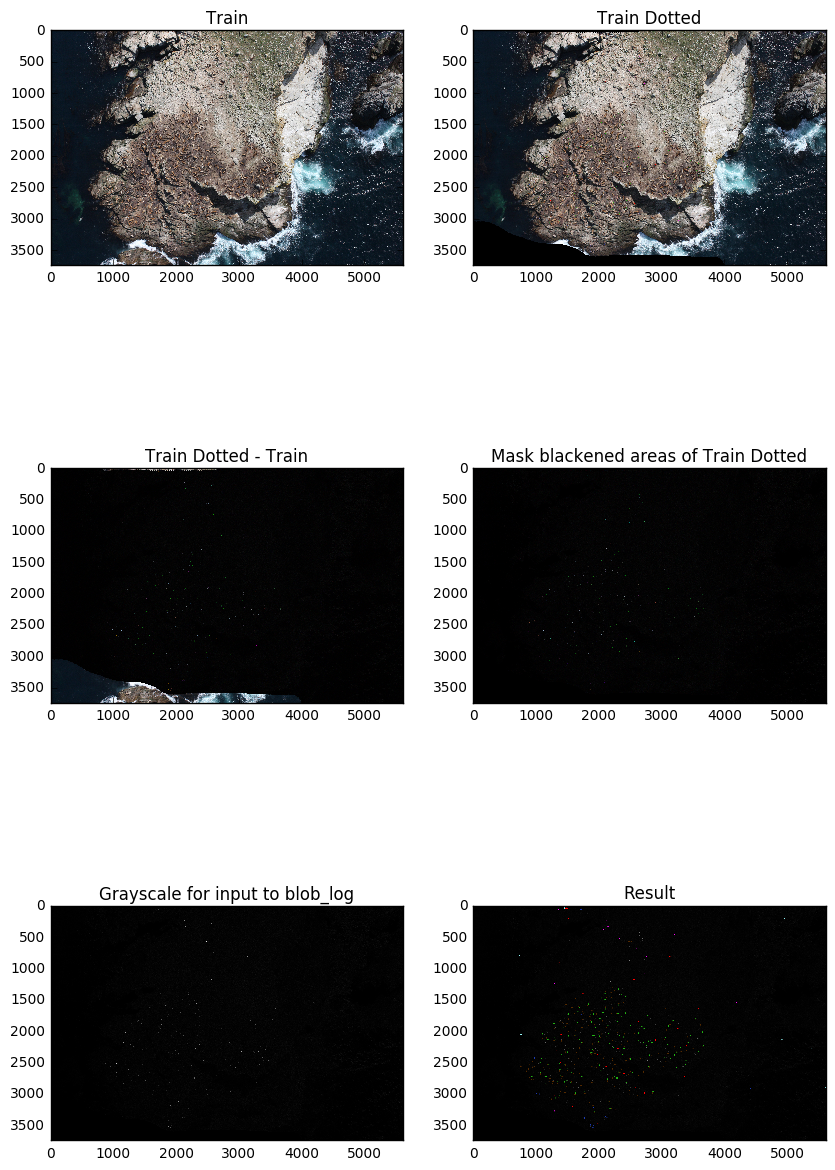

In [4]:
# dataframe to store results in
count_df = pd.DataFrame(index=file_names, columns=classes).fillna(0)
coords = []

for filename in file_names:
    print(filename)
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread("/data/x/sealion/TrainDotted/" + filename)
    image_2 = cv2.imread("/data/x/sealion/Train/" + filename)
    
    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1, image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_5 = cv2.bitwise_or(image_4, image_4, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_6 = cv2.cvtColor(image_5, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    # prepare the image to plot the results on
    image_7 = cv2.cvtColor(image_6, cv2.COLOR_GRAY2BGR)
    
    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        b, g, r = image_1[int(y)][int(x)][:]
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        cls = ""
        if r > 200 and b < 50 and g < 50: # RED
            cls = "adult_males"
            cv2.circle(image_7, (int(x), int(y)), 8, (0,0,255), 2)            
        elif r > 200 and b > 200 and g < 50: # MAGENTA
            cls = "subadult_males"
            cv2.circle(image_7, (int(x), int(y)), 8, (250,10,250), 2)            
        elif r < 100 and b < 100 and 150 < g < 200: # GREEN
            cls = "pups"
            cv2.circle(image_7, (int(x), int(y)), 8, (20,180,35), 2) 
        elif r < 100 and 100 < b and g < 100: # BLUE
            cls = "juveniles"
            cv2.circle(image_7, (int(x), int(y)), 8, (180,60,30), 2)
        elif r < 150 and b < 50 and g < 100:  # BROWN
            cls = "adult_females"
            cv2.circle(image_7, (int(x), int(y)), 8, (0,42,84), 2)            
        else:
            cls = "error"            
            cv2.circle(image_7, (int(x), int(y)), 8, (255,255,155), 2)
            
        count_df[cls][filename] += 1
        record = dict(filename=filename, x=x, y=y, category=cls)
        if cls != "error":
            coords.append(record)
        coords_df = pd.DataFrame.from_records(coords, columns=coords_cols)
        coords_df.x = coords_df.x.astype('int')
        coords_df.y = coords_df.y.astype('int')
    # output the results
          
    f, ax = plt.subplots(3,2,figsize=(10,16))
    (ax1, ax2, ax3, ax4, ax5, ax6) = ax.flatten()
    plt.title('%s'%filename)
    
    ax1.imshow(cv2.cvtColor(image_2[:,:,:], cv2.COLOR_BGR2RGB))
    ax1.set_title('Train')
    ax2.imshow(cv2.cvtColor(image_1[:,:,:], cv2.COLOR_BGR2RGB))
    ax2.set_title('Train Dotted')
    ax3.imshow(cv2.cvtColor(image_3[:,:,:], cv2.COLOR_BGR2RGB))
    ax3.set_title('Train Dotted - Train')
    ax4.imshow(cv2.cvtColor(image_5[:,:,:], cv2.COLOR_BGR2RGB))
    ax4.set_title('Mask blackened areas of Train Dotted')
    ax5.imshow(image_6[:,:], cmap='gray')
    ax5.set_title('Grayscale for input to blob_log')
    ax6.imshow(cv2.cvtColor(image_7[:,:,:], cv2.COLOR_BGR2RGB))
    ax6.set_title('Result')

    plt.show()

### Check count results

In [5]:
count_df

,adult_males,subadult_males,adult_females,juveniles,pups,error
290.jpg,0,0,22158,456,0,44653
291.jpg,42,20,275,24,236,20


### Reference counts

In [6]:
reference = pd.read_csv('/data/x/sealion/Train/train.csv')
reference.ix[indices]

,train_id,adult_males,subadult_males,adult_females,juveniles,pups
290,290,2,0,0,0,0
291,291,39,20,275,23,237


In [7]:
coords_df.to_csv('coords_notebook-bad2.csv', index=False)
count_df.to_csv('counts-bad2.csv', index=False)